![](https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png)

# 0. Introduction

**Process:**  
By process we mean a collection of discrete events (activities) in order to achieve a certain goal.

**Process mining:**  
A set of techniques used for obtaining knowledge of and extracting insights from processes by the means of analyzing the event data, generated during the execution of the process. The end goal of process mining is to discover, model, monitor, and optimize the underlying processes.

**Potential benefits of process mining:**
- Process discovery — Converting an event log into a process model.
- Conformance checking — Investigating the differences between the model and what happens in real life. This way the companies can identify deviations from the model and determine their severity/cost.
- Throughput analysis/bottleneck detection — Accounting for the intensity of events’ execution (measured by time spent to complete a particular event) in order to determine potential bottlenecks. This kind of analysis can be used to improve time-related KPIs by minimizing throughput/overhead time.

**Event log:**   
In order to carry out process mining, a dataset must contain (at least) the following 3 types of information:
- Case ID — A unique identifier of an entity going through the process. A common example could be the user’s unique ID, although, many possibilities are valid (it depends on the use case).
- Event — A step of the process, any activity that is a part of the process being analyzed.
- Timestamp — Used for performance evaluation and determining the order of events, can be the time when the user entered/exited the given event (or both actually).

**Petri net:**  
A Petri net - also known as a place/transition (PT) net - consists of _places_, _transitions_, and _arcs_ (a.k.a. _flow releations_). Arcs run from a place to a transition or vice versa, never between places or between transitions. The places from which an arc runs to a transition are called the input places of the transition; the places to which arcs run from a transition are called the output places of the transition. 

# 1. Setup

## 1.1 Packages

In [1]:
# general
import sys
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py

# object.log
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# algo.discovery
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# algo.filtering
from pm4py.algo.filtering.log.auto_filter.auto_filter import apply_auto_filter

# algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# vizualization
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# statistics
from pm4py.statistics.traces.log import case_statistics

## 1.2 Environment

In [2]:
print(f'platform     {sys.platform}')
print(f'environment  {sys.prefix}')
print(f'python       {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')

platform     linux
environment  /home/rene/miniconda3/envs/datascience
python       3.8.5


## 1.3 Versions

In [3]:
pd.DataFrame(
    [
        ['pandas', pd.__version__], 
        ['numpy ', np.__version__], 
        ['matplotlib', sys.modules['matplotlib'].__version__], 
        ['seaborn', sns.__version__],
        ['pm4py', pm4py.__version__]
    ], 
    columns = ['package', 'version']
).set_index('package')

,version
package,
pandas,1.2.0
numpy,1.19.2
matplotlib,3.3.2
seaborn,0.11.1
pm4py,2.1.3.2


## 1.4 Directories

In [4]:
directories = ['log', 'output']

In [5]:
for directory in directories:
    if not os.path.isdir(directory):
        os.mkdir(directory)

## 1.5 Setting

In [6]:
pd.set_option('display.max_rows', 50)

In [7]:
sns.set_theme()

## 1.6 Functions

In [8]:
def directly_follows_frequency_matrix(event_log: pd.DataFrame, 
                                      case_var: str, 
                                      event_var: str, 
                                      timestamp_var: str
                                     ) -> pd.DataFrame:
    """
    Return a directly-follows frequency matrix based on the traces in the event log.
    Events in the index are events 'from' and events in the columns are events 'to'.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate footprint matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events).fillna(0)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
        .drop([case_var, timestamp_var], axis = 1)\
        .rename(columns = {event_var:'event_from'})
        event['event_to'] = event['event_from'].shift(-1)
        event.dropna(inplace = True)
        
        # loop through traces
        for trace in event.itertuples(index = False):
            matrix.at[trace.event_from, trace.event_to] += 1
                
    return matrix.replace(0, np.nan)

In [9]:
def directly_follows_frequency_table(arc_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Returns an directly_follows frequency table
    """
    
    arcs = list()
    
    for row in arc_matrix.index:
        for col in arc_matrix.columns:
            if not np.isnan(arc_matrix.at[row, col]):
                arcs.append((row, col, arc_matrix.at[row, col]))
    
    arc_freq = pd.DataFrame(arcs, columns = ['event_from', 'event_to', 'frequency'])\
    .set_index(['event_from', 'event_to'])
    
    return arc_freq

In [10]:
def directly_follows_duration_matrix(event_log: pd.DataFrame, 
                                     case_var: str, 
                                     event_var: str, 
                                     timestamp_var: str, 
                                     duration: str ='h'
                                    ) -> pd.DataFrame:
    """
    Return a directly-follows duration matrix based on the traces in the event log.
    Events in the index are events 'from' and events in the columns are events 'to'.
    By default duration is set to hours (h).
    Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate footprint matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
        .rename(columns = {event_var:'event_from', timestamp_var:'time_begin'})
        event['event_to'] = event['event_from'].shift(-1)
        event['time_end'] = event['time_begin'].shift(-1)
        event['duration'] = (event['time_end'] - event['time_begin']) / np.timedelta64(1, duration)
        event.dropna(inplace = True)
        
        # loop through traces
        for row in event.itertuples(index = False):
            matrix.at[row.event_from, row.event_to] = \
            np.nansum([matrix.at[row.event_from, row.event_to], row.duration])
    
    return matrix.astype(float)

In [11]:
def duration(event_log: pd.DataFrame, 
             case_var: str, 
             event_var: str, 
             timestamp_var: str, 
             duration: str ='h'
            ) -> pd.DataFrame:
    """
    Returns an egde list with durations.
    By default duration is set to hours (h).
    Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    data = dict()
    groups = log_csv.groupby(case_var)
    for group in groups:
        arc = group[1].sort_values(timestamp_var).rename(columns = {event_var:'event_from', timestamp_var:'time_from'})
        arc['event_to'] = arc['event_from'].shift(-1)
        arc['time_to'] = arc['time_from'].shift(-1)
        arc.dropna(inplace = True)
        duration_var = f'duration ({duration})'
        arc[duration_var] = (arc['time_to'] - arc['time_from']) / np.timedelta64(1, duration)
        data[group[0]] = arc[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]]
    return pd.concat(data.values()).set_index(case_var)

# 2. Data Prepatation

## 2.1 Read Data

In [12]:
log_csv = pd.read_csv('data/running-example.csv', sep=';')

## 2.2 Convert Data

In [13]:
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

## 2.3 Explore Data

In [14]:
# Shape
log_csv.shape

(42, 5)

In [15]:
# Check NA-values
log_csv.isna().sum()

case_id      0
activity     0
timestamp    0
costs        0
resource     0
dtype: int64

In [16]:
# Info
log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   case_id    42 non-null     int64              
 1   activity   42 non-null     object             
 2   timestamp  42 non-null     datetime64[ns, UTC]
 3   costs      42 non-null     int64              
 4   resource   42 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 1.8+ KB


In [17]:
# Sample
log_csv.sample(n=7)

,case_id,activity,timestamp,costs,resource
27,5,decide,2011-01-10 12:28:00+00:00,200,Sara
34,5,check ticket,2011-01-21 10:34:00+00:00,100,Pete
39,4,examine thoroughly,2011-01-08 13:43:00+00:00,400,Sean
17,1,decide,2011-01-06 10:18:00+00:00,200,Sara
6,3,check ticket,2011-01-08 10:43:00+00:00,100,Pete
41,4,reject request,2011-01-12 14:44:00+00:00,200,Ellen
29,5,check ticket,2011-01-14 13:33:00+00:00,100,Ellen


In [18]:
# Unique values
pd.DataFrame(
    {
        'variable': log_csv.columns, 
        'unique values': [log_csv[col].nunique() for col in log_csv.columns],
        'fraction': [round(log_csv[col].nunique() / log_csv.shape[0], 2) for col in log_csv.columns], 
    }
).set_index('variable')

,unique values,fraction
variable,,
case_id,6,0.14
activity,8,0.19
timestamp,41,0.98
costs,4,0.10
resource,6,0.14


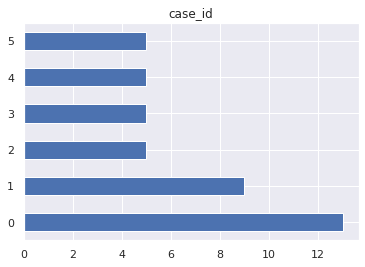

In [19]:
# Value counts: case_id
log_csv.case_id.value_counts().reset_index(drop=True).plot(y='case_id', kind='barh', title='case_id')
plt.show()

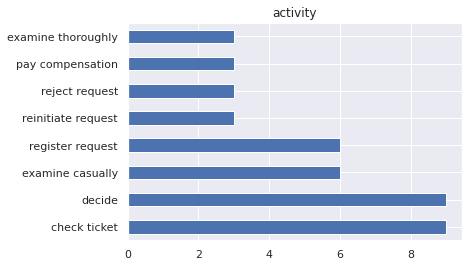

In [20]:
# Value counts: activity
log_csv.activity.value_counts().plot(y='activity', kind='barh', title='activity')
plt.show()

In [21]:
# Unique values: timestamp
log_csv.timestamp.nunique()

41

In [22]:
# Multiple occurences: timestamp
log_csv.timestamp.value_counts()[log_csv.timestamp.value_counts() > 1]

2011-01-06 14:02:00+00:00    2
Name: timestamp, dtype: int64

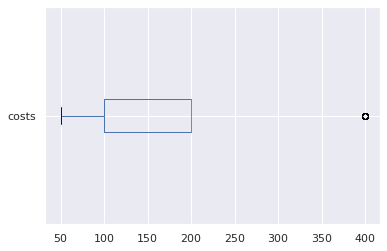

In [23]:
# Value distrubution: costs
log_csv.costs.plot(kind='box', vert=False)
plt.show()

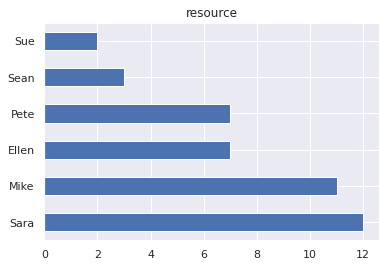

In [24]:
# Value counts: resource
log_csv.resource.value_counts().plot(y='resource', kind='barh', title='resource')
plt.show()

In [25]:
# Sort data
log_csv.sort_values(['case_id', 'timestamp'])

,case_id,activity,timestamp,costs,resource
14,1,register request,2010-12-30 10:02:00+00:00,50,Pete
15,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue
16,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike
17,1,decide,2011-01-06 10:18:00+00:00,200,Sara
18,1,reject request,2011-01-07 13:24:00+00:00,200,Pete
9,2,register request,2010-12-30 10:32:00+00:00,50,Mike
10,2,check ticket,2010-12-30 11:12:00+00:00,100,Mike
11,2,examine casually,2010-12-30 13:16:00+00:00,400,Sean
12,2,decide,2011-01-05 10:22:00+00:00,200,Sara
13,2,pay compensation,2011-01-08 11:05:00+00:00,200,Ellen


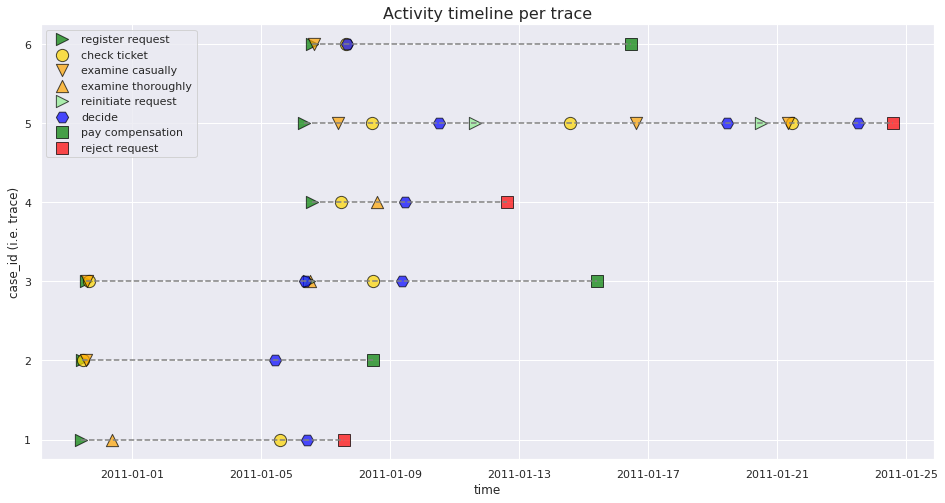

In [26]:
# Visualize eventlog
activity = {
    'register request': ('>', 'green'), 
    'check ticket': ('o', 'gold'), 
    'examine casually': ('v', 'orange'), 
    'examine thoroughly': ('^', 'orange'), 
    'reinitiate request': ('>', 'lightgreen'), 
    'decide': ('H', 'blue'), 
    'pay compensation': ('s', 'green'), 
    'reject request': ('s', 'red'),
}

fig, ax = plt.subplots(figsize=(16, 8))

# timelines
for timeline in log_csv.groupby('case_id').agg(time_start = ('timestamp', min), 
                                               time_end = ('timestamp', max)
                                              ).reset_index().itertuples(index=False):
    plt.hlines(timeline.case_id, timeline.time_start, timeline.time_end, 
               colors = 'grey', linestyles = 'dashed')

# activities
for act in activity.keys():
    ax.scatter(log_csv.loc[log_csv.activity == act, 'timestamp'], 
               log_csv.loc[log_csv.activity == act, 'case_id'],
               marker = activity[act][0],
               color = activity[act][1], 
               s = 150, 
               alpha = .7,
               label = act,
               edgecolors = 'black',
              )
    
ax.set_title('Activity timeline per trace', fontsize=16)
ax.set_xlabel('time')
ax.set_ylabel('case_id (i.e. trace)')
ax.legend()
ax.grid(True)

plt.show()

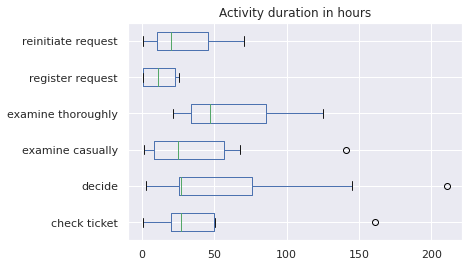

In [27]:
# Boxplot activity duration
duration(log_csv, 'case_id', 'activity', 'timestamp')\
.loc[:, ['event_from', 'event_to', 'duration (h)']]\
.reset_index()\
.pivot(columns='event_from', values='duration (h)')\
.plot(kind='box', vert=False, title='Activity duration in hours')
plt.show()

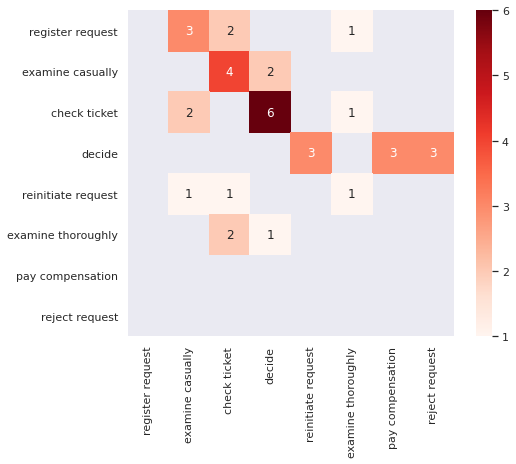

In [28]:
# Directly-Follows frequency matrix
dff_matrix = directly_follows_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(dff_matrix, annot=True, fmt='.0f', cmap='Reds', square=True)
plt.show()

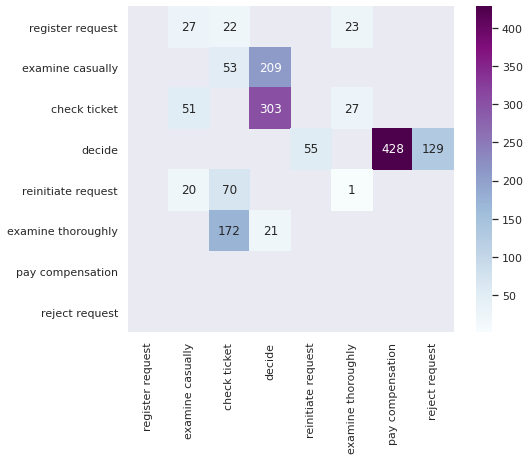

In [29]:
# Directly-Follows total duration matrix in hours
dff_matrix = directly_follows_duration_matrix(log_csv, 'case_id', 'activity', 'timestamp', duration='h')
sns.set(rc={'figure.figsize':(8, 6)})
sns.heatmap(dff_matrix, annot=True, fmt='.0f', cmap='BuPu', square=True)
plt.show()

In [30]:
# Directly-Follows frequency and average duration in hours
df = pd.merge(
    directly_follows_frequency_table(
        directly_follows_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp'))\
    .reset_index(),
    duration(log_csv, 'case_id', 'activity', 'timestamp')\
    .loc[:, ['event_from', 'event_to', 'duration (h)']]\
    .groupby(by = ['event_from', 'event_to']).mean('duration (h)')\
    .reset_index(),
    left_on = ['event_from', 'event_to'],
    right_on = ['event_from', 'event_to']
).rename(columns = {'duration (h)':'average_duration_in_hours'})

df['average_duration_in_hours'] = df['average_duration_in_hours'].apply(lambda x: np.round(x, decimals=2))
df['frequency'] = df['frequency'].astype(int)

df.sort_values(['average_duration_in_hours', 'frequency'], ascending=False)

,event_from,event_to,frequency,average_duration_in_hours
9,decide,pay compensation,3,142.82
4,examine casually,decide,2,104.28
14,examine thoroughly,check ticket,2,85.86
12,reinitiate request,check ticket,1,70.25
6,check ticket,decide,6,50.54
10,decide,reject request,3,42.84
7,check ticket,examine thoroughly,1,26.62
5,check ticket,examine casually,2,25.68
2,register request,examine thoroughly,1,23.07
15,examine thoroughly,decide,1,21.32


# 3. Event Log

## 3.1 Create Event Log

In [31]:
event_log = pm4py.format_dataframe(
    log_csv,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

## 3.2 View Event Log

In [32]:
event_log.head()

,case:concept:name,concept:name,time:timestamp,costs,resource,@@index
14,1,register request,2010-12-30 10:02:00+00:00,50,Pete,14
15,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue,15
16,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike,16
17,1,decide,2011-01-06 10:18:00+00:00,200,Sara,17
18,1,reject request,2011-01-07 13:24:00+00:00,200,Pete,18


In [33]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)

In [34]:
print(f'Start activities: {start_activities}')
print(f'End activities  : {end_activities}')

Start activities: {'register request': 6}
End activities  : {'reject request': 3, 'pay compensation': 3}


## 3.3. Export Event Log (to XES)

In [35]:
xes_exporter.apply(event_log, 'log/running-example.xes')

exporting log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

## 3.4. Import Event Log (from XES)

In [36]:
log = xes_importer.apply('log/running-example.xes')

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

## 3.5 Event Log (XES)

In [37]:
# EventLog
type(log)

pm4py.objects.log.log.EventLog

In [38]:
# Trace
type(log[0])

pm4py.objects.log.log.Trace

In [39]:
# Trace
type(log[0][0])

pm4py.objects.log.log.Event

In [40]:
# concept:name (i.e case_id) for each trace
[trace.attributes['concept:name'] for trace in log]

['1', '2', '3', '4', '5', '6']

In [41]:
# Overview traces from XES
for trace in log:
    print('== TRACE: {} =================================================='\
          .format(trace.attributes['concept:name'])
         )
    for event in trace:
        print('{:>18}:  {:>3}  |  {:>5}  |  {}  |  {:>2}'.format(
            event.get('concept:name'), 
            event.get('costs'), 
            event.get('resource'), 
            event.get('time:timestamp').strftime('%Y-%m-%d %H:%M'), 
            event.get('@@index')
        ))
    print()

== TRACE: 1 ==================================================
  register request:   50  |   Pete  |  2010-12-30 10:02  |  14
examine thoroughly:  400  |    Sue  |  2010-12-31 09:06  |  15
      check ticket:  100  |   Mike  |  2011-01-05 14:12  |  16
            decide:  200  |   Sara  |  2011-01-06 10:18  |  17
    reject request:  200  |   Pete  |  2011-01-07 13:24  |  18

== TRACE: 2 ==================================================
  register request:   50  |   Mike  |  2010-12-30 10:32  |   9
      check ticket:  100  |   Mike  |  2010-12-30 11:12  |  10
  examine casually:  400  |   Sean  |  2010-12-30 13:16  |  11
            decide:  200  |   Sara  |  2011-01-05 10:22  |  12
  pay compensation:  200  |  Ellen  |  2011-01-08 11:05  |  13

== TRACE: 3 ==================================================
  register request:   50  |   Pete  |  2010-12-30 13:32  |   0
  examine casually:  400  |   Mike  |  2010-12-30 14:06  |   1
      check ticket:  100  |  Ellen  |  2010-12-30 15:

In [42]:
# Start activities
pm4py.get_start_activities(log)

{'register request': 6}

In [43]:
# End activities
pm4py.get_end_activities(log)

{'reject request': 3, 'pay compensation': 3}

In [44]:
# Filter on end activity 'pay compensation'
pay_compensation = pm4py.filter_end_activities(log, {'pay compensation'})
pay_compensation

[{'attributes': {'concept:name': '2'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2010, 12, 30, 10, 32, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Mike', '@@index': 9}, '..', {'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 8, 11, 5, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Ellen', '@@index': 13}]}, '....', {'attributes': {'concept:name': '6'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2011, 1, 6, 14, 2, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Mike', '@@index': 19}, '..', {'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 16, 10, 47, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Mike', '@@index': 23}]}]

In [45]:
# Traces (i.e. case_id) with and activity 'pay compensation'
for trace in pay_compensation:
    print(trace.attributes['concept:name'])

2
3
6


In [46]:
# Filter methods
[_ for _ in dir(pm4py) if _.startswith('filter')]

['filter_attribute_values',
 'filter_directly_follows_relation',
 'filter_end_activities',
 'filter_event_attribute_values',
 'filter_eventually_follows_relation',
 'filter_log',
 'filter_start_activities',
 'filter_time_range',
 'filter_trace',
 'filter_trace_attribute',
 'filter_trace_attribute_values',
 'filter_variants',
 'filter_variants_percentage',
 'filtering']

In [47]:
# Filter on traces that did start and end in 2011
start_datetime = datetime.datetime(2011, 1, 1, 0, 0, 0, 0)
end_datetime = datetime.datetime(2011, 12, 31, 23, 59, 59, 999999)
log_2011 = pm4py.filter_time_range(log, start_datetime, end_datetime, mode='traces_contained')

# Print case_id's (traces) in 20111
for trace in log_2011:
    print(trace.attributes['concept:name'])

4
5
6


# 4. Process Dicovery

## 4.1 Alpha Miner

The alpha miner is one of the most known Process Discovery algorithm and is able to find:

- A [Petri net](https://en.wikipedia.org/wiki/Petri_net) model where all the transitions are visible and unique and correspond to classified events (for example, to activities).
- An initial marking that describes the status of the Petri net model when a execution starts.
- A final marking that describes the status of the Petri net model when a execution ends.

### 4.1.1 Miner

In [48]:
# Miner
net, initial_marking, final_marking = alpha_miner.apply(log)

### 4.1.2 Petri net

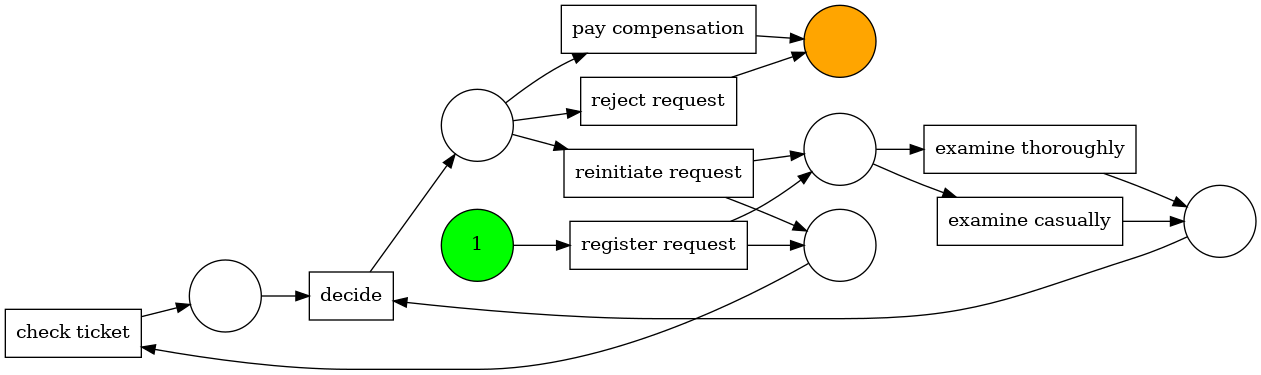

In [49]:
# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_pn.png')

# View
pn_visualizer.view(gviz)

#### Trying to understanding the model ....

- The _place_ colored green is the _source place_ and belongs to the initial marking.
- In the initial marking, a token is assigned to that place (indicated by the number 1 on the place).
- The _place_ colored orange is the _sink place_ and belongs to the final marking. We see that _transitions_ here correspond to activities in the log.
- There are no direct connections between _transitions_ (i.e. between the rectangles in the model which represent activities).
- _Transitions_ are connected via _places_ and are represented by the circles in the model.
- _Transitions_ and _points_ are connected by _arcs_.
- See `net.transitions`, `net.places` and `net.arcs` for details.
- Models extracted by the Alpha Miner often have deadlock problems, so it is not sure that each trace is replayable on this model.

#### Assertions

In [50]:
# assert number of transitions
assert log_csv.activity.nunique() == len(net.transitions)

# assert transition names
assert set(log_csv.activity) == set(str(transition) for transition in net.transitions)

# assert start and end activities
start_activities_csv = list()
end_activities_csv = list()

for group in log_csv.sort_values('timestamp').groupby('case_id'):
    start_activities_csv.append(group[1].iloc[0, 1]) # append first (trace) activity to list
    end_activities_csv.append(group[1].iloc[-1, 1]) # append last (trace) activity to list 

start_activities_net = list()
end_activities_net = list()

for arc in list(net.arcs):
    if str(arc.source) == 'start': start_activities_net.append(str(arc).split('(t)')[-1])
    if str(arc.target) == 'end': end_activities_net.append(str(arc).split('->')[0].replace('(t)', ''))

assert set(end_activities_csv) == set(end_activities_net)

#### Questions

- Not clear how the _Alpha Miner_ algoritme works, especially the way _points_ and _arcs_ are determined. In "Table 1" are the directly-follows (i.e. "arcs") as extracted from the csv-logfile.  In "Table 2" are the _arcs_ as determined by the _Alpha Miner_ algoritme. Seems like the follwing directly-follows are missing:
  - check ticket -> examine casually
  - examine casually -> check ticket
  - check ticket -> examine thoroughly
  - examine thoroughly -> check ticket
- These four maybe missing because they are "circulair flow relations". I guess that the _Alpha Miner_ algo does not support that type of flow relation. 

In [51]:
# Table 1: Directly Follows frequency table (from log_csv)
directly_follows_frequency_table(
    directly_follows_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
).astype(int)

frequency
event_from         event_to                     
register request   examine casually            3
                   check ticket                2
                   examine thoroughly          1
examine casually   check ticket                4
                   decide                      2
check ticket       examine casually            2
                   decide                      6
                   examine thoroughly          1
decide             reinitiate request          3
                   pay compensation            3
                   reject request              3
reinitiate request examine casually            1
                   check ticket                1
                   examine thoroughly          1
examine thoroughly check ticket                2
                   decide                      1

In [52]:
# Table 2
net.arcs

{(p)({'check ticket'}, {'decide'})->(t)decide,
 (p)({'decide'}, {'reinitiate request', 'reject request', 'pay compensation'})->(t)pay compensation,
 (p)({'decide'}, {'reinitiate request', 'reject request', 'pay compensation'})->(t)reinitiate request,
 (p)({'decide'}, {'reinitiate request', 'reject request', 'pay compensation'})->(t)reject request,
 (p)({'examine casually', 'examine thoroughly'}, {'decide'})->(t)decide,
 (p)({'reinitiate request', 'register request'}, {'check ticket'})->(t)check ticket,
 (p)({'reinitiate request', 'register request'}, {'examine casually', 'examine thoroughly'})->(t)examine casually,
 (p)({'reinitiate request', 'register request'}, {'examine casually', 'examine thoroughly'})->(t)examine thoroughly,
 (p)start->(t)register request,
 (t)check ticket->(p)({'check ticket'}, {'decide'}),
 (t)decide->(p)({'decide'}, {'reinitiate request', 'reject request', 'pay compensation'}),
 (t)examine casually->(p)({'examine casually', 'examine thoroughly'}, {'decide'}),
 

### 4.1.3 Petri net with frequency information

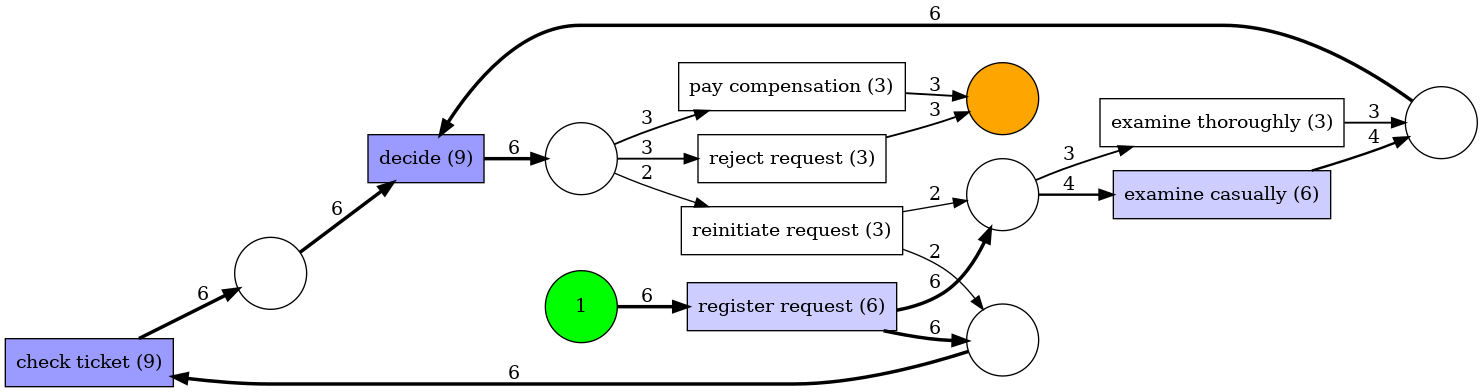

In [53]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'} # svg

# GraphViz
gviz = pn_visualizer.apply(
    net, initial_marking, final_marking,
    parameters=parameters, 
    variant=pn_visualizer.Variants.FREQUENCY, 
    log=log
)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_pn_frequency.png') # .svg

# View
pn_visualizer.view(gviz)

#### Trying to understanding the model ....

- Same as Petri net (without frequencies), plus ...
- The frequencies for the _transitions_ (i.e. activities) are as expected

#### Assertions

In [54]:
# assert number of transitions
assert log_csv.activity.nunique() == len(net.transitions)

# assert transition names
assert set(log_csv.activity) == set(str(transition) for transition in net.transitions)

#### Questions

- Same as Petri net (without frequencies), plus ...
- The edge count for 'check ticket --> decide' in the model is 6. That is equal to my own counts in "Table 1". The same applies for 'decide --> pay compensation' and 'decide --> 'reject request'. However, 'decide --> reinitiate request' has a count of 2 in the model and 3 in table 1. Not clear how the frequencies around the places are calculated in the model. From transition 'decide (9)' in the model there is a count of 6 to a point. And from that point there are arc counts 3, 3 and 2. So 6 in and 8 out?
- Any suggestion how to explain the model and translate/map it to 'reality' (what lessons can be learned from the model and the counts)?
- Any suggestions on how to reproduce the counts from the csv-logfile?

In [55]:
# Table 1: Directly Follows frequency table (from log_csv)
directly_follows_frequency_table(
    directly_follows_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
).reset_index()

,event_from,event_to,frequency
0,register request,examine casually,3.0
1,register request,check ticket,2.0
2,register request,examine thoroughly,1.0
3,examine casually,check ticket,4.0
4,examine casually,decide,2.0
5,check ticket,examine casually,2.0
6,check ticket,decide,6.0
7,check ticket,examine thoroughly,1.0
8,decide,reinitiate request,3.0
9,decide,pay compensation,3.0


## 4.2 Directly-Follows Graph

Directly-Follows graphs are graphs where the nodes represent the events/activities in the log and directed edges are present between nodes if there is at least a trace in the log where the source event/activity is followed by the target event/activity. On top of these directed edges, it is easy to represent metrics like frequency (counting the number of times the source event/activity is followed by the target event/activity) and performance (some aggregation, for example, the mean, of time inter-lapsed between the two events/activities).

### 4.2.1 Directly-Follows Graph (frequency)

In [56]:
# Miner
dfg = dfg_discovery.apply(log)

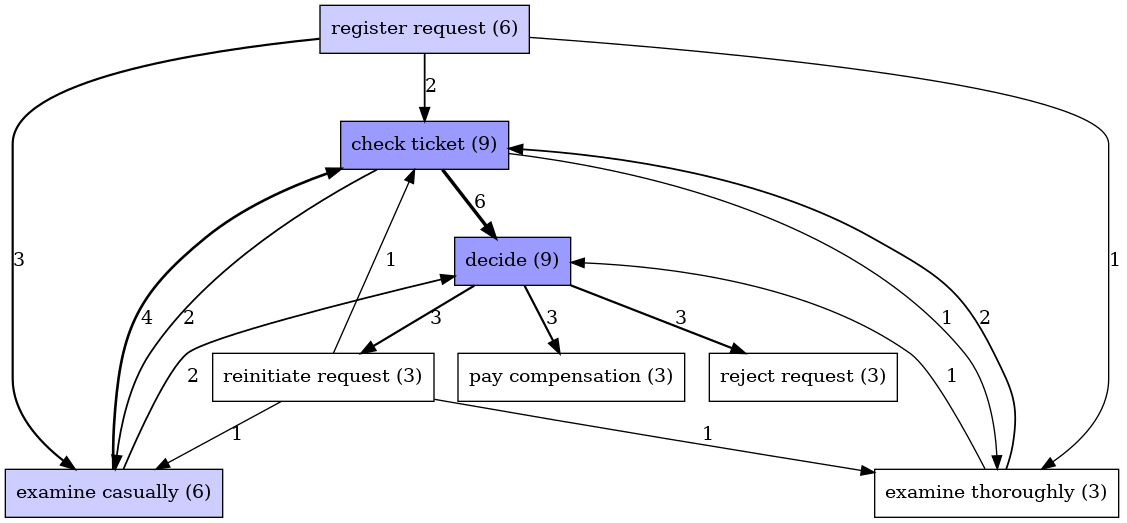

In [57]:
# GraphViz
gviz = dfg_visualization.apply(
    dfg,
    log = log,
    variant = dfg_visualization.Variants.FREQUENCY
)

# Save
dfg_visualization.save(gviz, 'output/dfg_frequency.png')

# View
dfg_visualization.view(gviz)

#### Trying to understanding the model ....

- Transitions and transition counts as expected
- Arcs (flow relations) and arc counts as expected

In [58]:
# activity frequency
log_csv.activity.value_counts()

check ticket          9
decide                9
examine casually      6
register request      6
reinitiate request    3
reject request        3
pay compensation      3
examine thoroughly    3
Name: activity, dtype: int64

In [59]:
# Directly Follows frequency table (from log_csv)
directly_follows_frequency_table(
    directly_follows_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
)

frequency
event_from         event_to                     
register request   examine casually          3.0
                   check ticket              2.0
                   examine thoroughly        1.0
examine casually   check ticket              4.0
                   decide                    2.0
check ticket       examine casually          2.0
                   decide                    6.0
                   examine thoroughly        1.0
decide             reinitiate request        3.0
                   pay compensation          3.0
                   reject request            3.0
reinitiate request examine casually          1.0
                   check ticket              1.0
                   examine thoroughly        1.0
examine thoroughly check ticket              2.0
                   decide                    1.0

#### Assertions

In [60]:
# assert number of transitions
assert log_csv.activity.nunique() == len(set([key[0] for key in dfg.keys()]\
                                             + [key[1] for key in dfg.keys()]))

# assert transition names
assert set(log_csv.activity) == set([key[0] for key in dfg.keys()] + [key[1] for key in dfg.keys()])

# assert transition frequencies
# no information available in 'dfg', however frequencies in the (visual) model resemble value counts on 'ĺog_csv'
# --> log_csv.activity.value_counts()

# assert arc frequencies
assert directly_follows_frequency_table(
    directly_follows_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
).to_dict()['frequency'].items() == dfg.items()

#### Questions

No questions! Directly-Follows Graph perfectly reproducible from the `log_csv'.

### 4.2.2 Directly-Follows Graph (performance)

Decorate the edges by using the performance metrics. By using the PERFORMANCE variant the average time elapsed between two nodes will be displayed.

In [61]:
# Miner
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

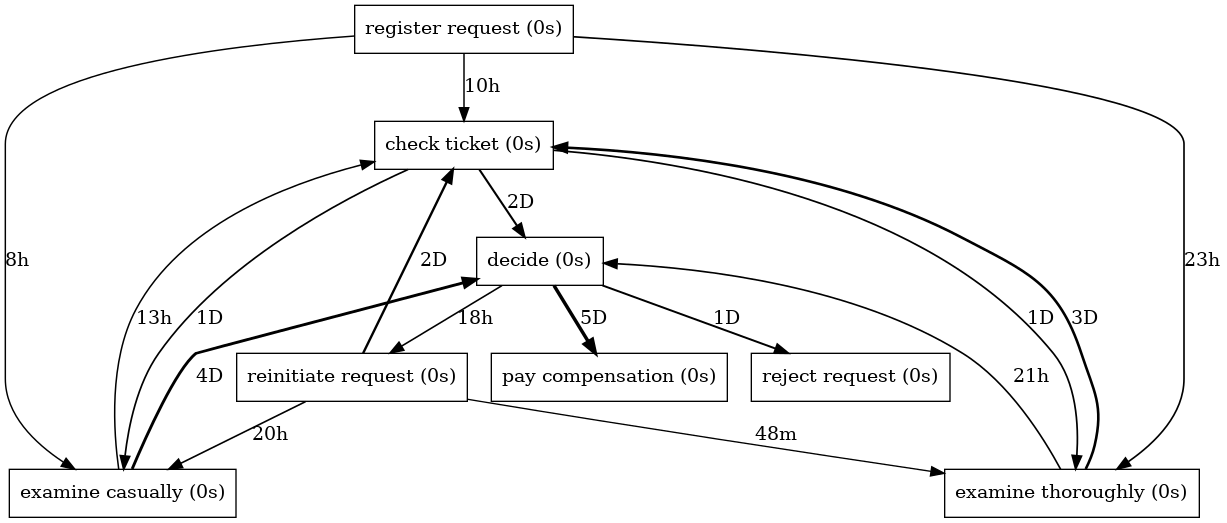

In [62]:
# GraphViz
gviz = dfg_visualization.apply(
    dfg,
    log = log,
    variant = dfg_visualization.Variants.PERFORMANCE
)

# Save
dfg_visualization.save(gviz, 'output/dfg_performance.png')

# View
dfg_visualization.view(gviz)

#### Trying to understanding the model ....

In [63]:
# Duration in days
duration_D = duration(log_csv, 'case_id', 'activity', 'timestamp', duration='D')\
.groupby(by = ['event_from', 'event_to']).mean('duration (D)')\
.reset_index()
duration_D['duration (D)'] = np.floor(duration_D['duration (D)']).astype(int)

# Duration in hours
duration_h = duration(log_csv, 'case_id', 'activity', 'timestamp', duration='h')\
.groupby(by = ['event_from', 'event_to']).mean('duration (h)')\
.reset_index()
duration_h['duration (h)'] = np.floor(duration_h['duration (h)']).astype(int)

# Duration in minutes
duration_m = duration(log_csv, 'case_id', 'activity', 'timestamp', duration='m')\
.groupby(by = ['event_from', 'event_to']).mean('duration (m)')\
.reset_index()
duration_m['duration (m)'] = np.floor(duration_m['duration (m)']).astype(int)

# Merge durations
Dhm = pd.merge(
    pd.merge(duration_D,
             duration_h,
             on=['event_from', 'event_to']
            ),
    duration_m,
    on=['event_from', 'event_to']
)

# Select durations
duration_list = list()
for row in Dhm.itertuples(index=False):
    if row._2 >= 1:
        duration_list.append(f'{row._2}D')
    elif row._3 >= 1:
        duration_list.append(f'{row._3}h')
    else:
        duration_list.append(f'{row._4}m')
Dhm['duration'] = duration_list

# View durations
Dhm[['event_from', 'event_to', 'duration']]

,event_from,event_to,duration
0,check ticket,decide,2D
1,check ticket,examine casually,1D
2,check ticket,examine thoroughly,1D
3,decide,pay compensation,5D
4,decide,reinitiate request,18h
5,decide,reject request,1D
6,examine casually,check ticket,13h
7,examine casually,decide,4D
8,examine thoroughly,check ticket,3D
9,examine thoroughly,decide,21h


#### Assertions

In [64]:
# Duration in seconds
duration_s = duration(log_csv, 'case_id', 'activity', 'timestamp', duration='s')\
.groupby(by = ['event_from', 'event_to']).mean('duration (s)')\
.reset_index()

# Dataframe to dictonary
duration_s_dict = dict()
for row in duration_s.itertuples(index=False):
    duration_s_dict[(row.event_from, row.event_to)] = int(row._2)

# Assert duration (in seconds)
assert duration_s_dict.items() == dfg.items()

#### Questions

No questions! Directly-Follows Graph performance perfectly reproducible from the `log_csv'.

### 4.2.3 Convert "Directly-Follows Graph" to "Petri Net"

In [65]:
# Miner
dfg = dfg_discovery.apply(log)

In [66]:
# Convert
net, initial_marking, final_marking = dfg_converter.apply(dfg)

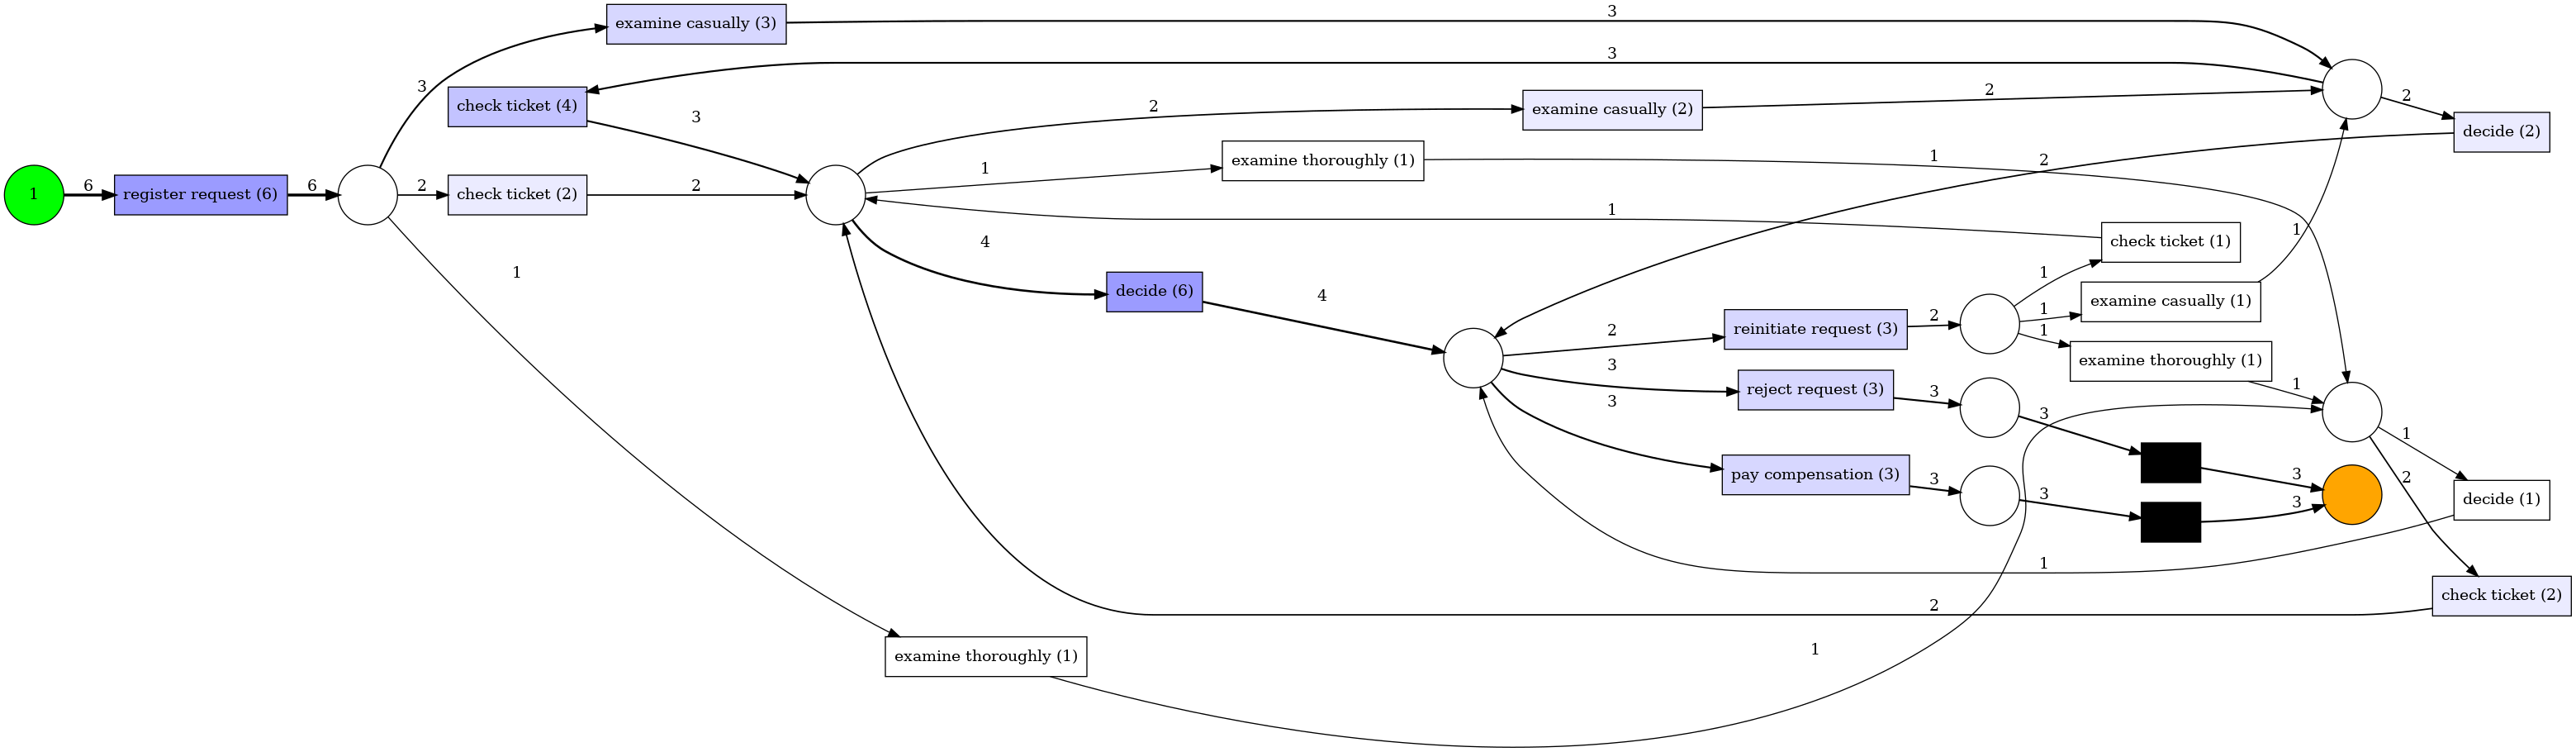

In [67]:
# GraphViz
gviz_freq = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.FREQUENCY, 
                           log = log)

# View
pn_visualizer.view(gviz_freq)

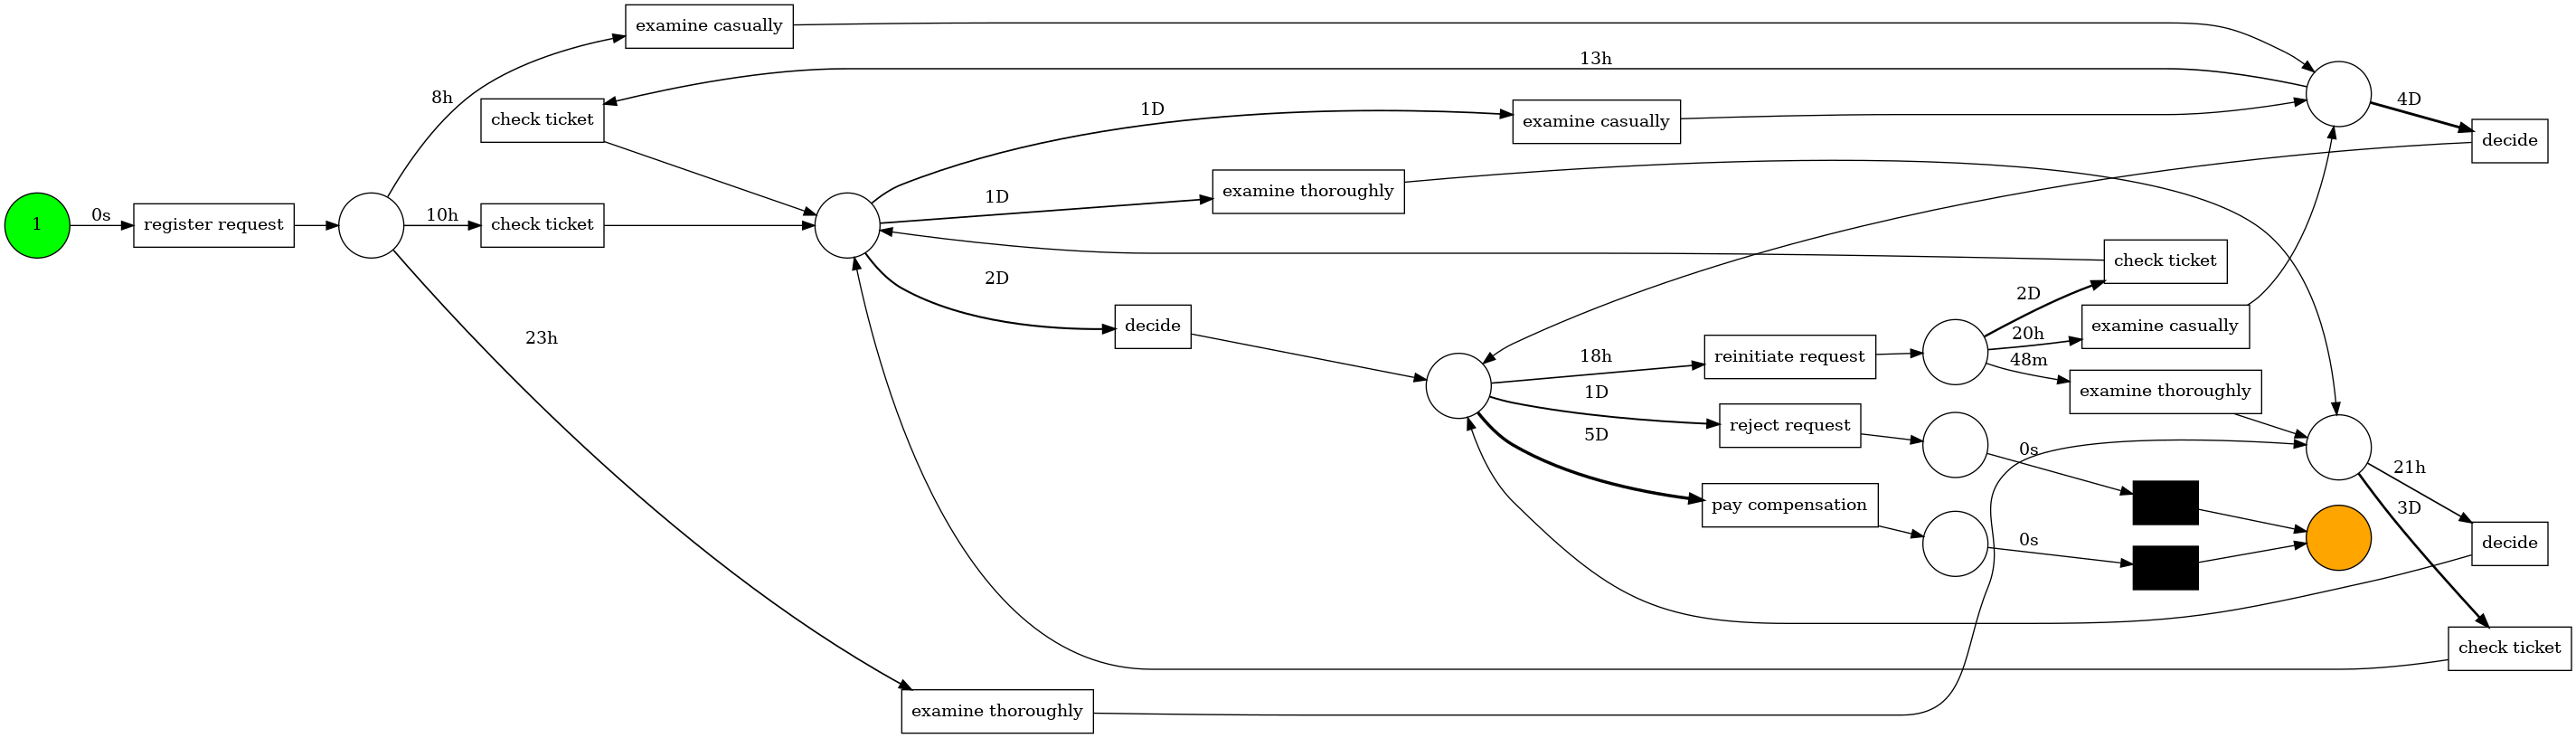

In [68]:
# GraphViz
gviz_perf = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant = pn_visualizer.Variants.PERFORMANCE, 
                           log = log)

# View
pn_visualizer.view(gviz_perf)

#### Trying to understanding the model ....

- In this Petri net we find some _hidden transitions_ (i.e. the black rectangles).

## 4.3 Heuristic Miner

Heuristics Miner is an algorithm that acts on the Directly-Follows Graph, providing way to handle with noise and to find common constructs (dependency between two activities). The output of the Heuristics Miner is an Heuristics Net, so an object that contains the activities and the relationships between them.

### 4.3.1 Heuristic Net

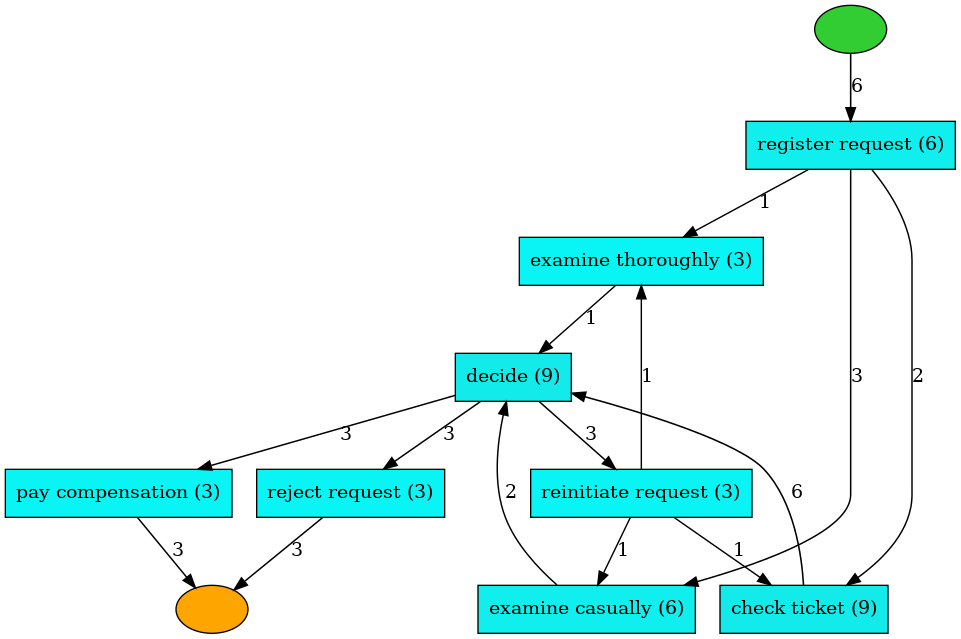

In [69]:
# Miner
heu_net = heuristics_miner.apply_heu(log)

# GraphViz
gviz = hn_visualizer.apply(heu_net)

# View
hn_visualizer.view(gviz)

#### Trying to understanding the model ....

- Transitions and transition counts as expected.
- Start activities as expected
- End activities as expected
- Most arcs as expected

#### Assertions

In [70]:
# assert activities
set(log_csv.activity.unique()) == set(heu_net.activities)

# assert activity frequencies
assert log_csv.activity.value_counts().to_dict() == heu_net.activities_occurrences

# assert arc frequencies
assert dict(set(((row.event_from, row.event_to), row.frequency) for row in directly_follows_frequency_table(directly_follows_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')).reset_index().itertuples(index=False))) == heu_net.dfg

# assert start and end activities
start_activities_csv = list()
end_activities_csv = list()

for group in log_csv.sort_values('timestamp').groupby('case_id'):
    start_activities_csv.append(group[1].iloc[0, 1])
    end_activities_csv.append(group[1].iloc[-1, 1])

assert set(start_activities_csv) == set(heu_net.start_activities[0].keys())
assert set(end_activities_csv) == set(heu_net.end_activities[0].keys())

#### Questions

- Not clear what causes the warning "Warning: # is not a known color."
- The assertions give no errors, however not all arcs are show in the Heuristic Net, like:
  - check ticket -> examine casually
  - examine casually -> check ticket
  - check ticket -> examine thoroughly
  - examine thoroughly -> check ticket
- These four maybe missing because they are "circulair flow relations". I guess that the _Heuristic Miner_ algo does not support that type of flow relations. 

In [71]:
# Table 1: Directly Follows frequency table (from log_csv)
directly_follows_frequency_table(
    directly_follows_frequency_matrix(log_csv, 'case_id', 'activity', 'timestamp')
).astype(int)

frequency
event_from         event_to                     
register request   examine casually            3
                   check ticket                2
                   examine thoroughly          1
examine casually   check ticket                4
                   decide                      2
check ticket       examine casually            2
                   decide                      6
                   examine thoroughly          1
decide             reinitiate request          3
                   pay compensation            3
                   reject request              3
reinitiate request examine casually            1
                   check ticket                1
                   examine thoroughly          1
examine thoroughly check ticket                2
                   decide                      1

### 4.3.2 Convert Heuristic  Net to Petri Net

The generated model is more complex than the one generated by the Alpha Miner.

In [72]:
# Miner
net, initial_marking, final_marking = heuristics_miner.apply(log)

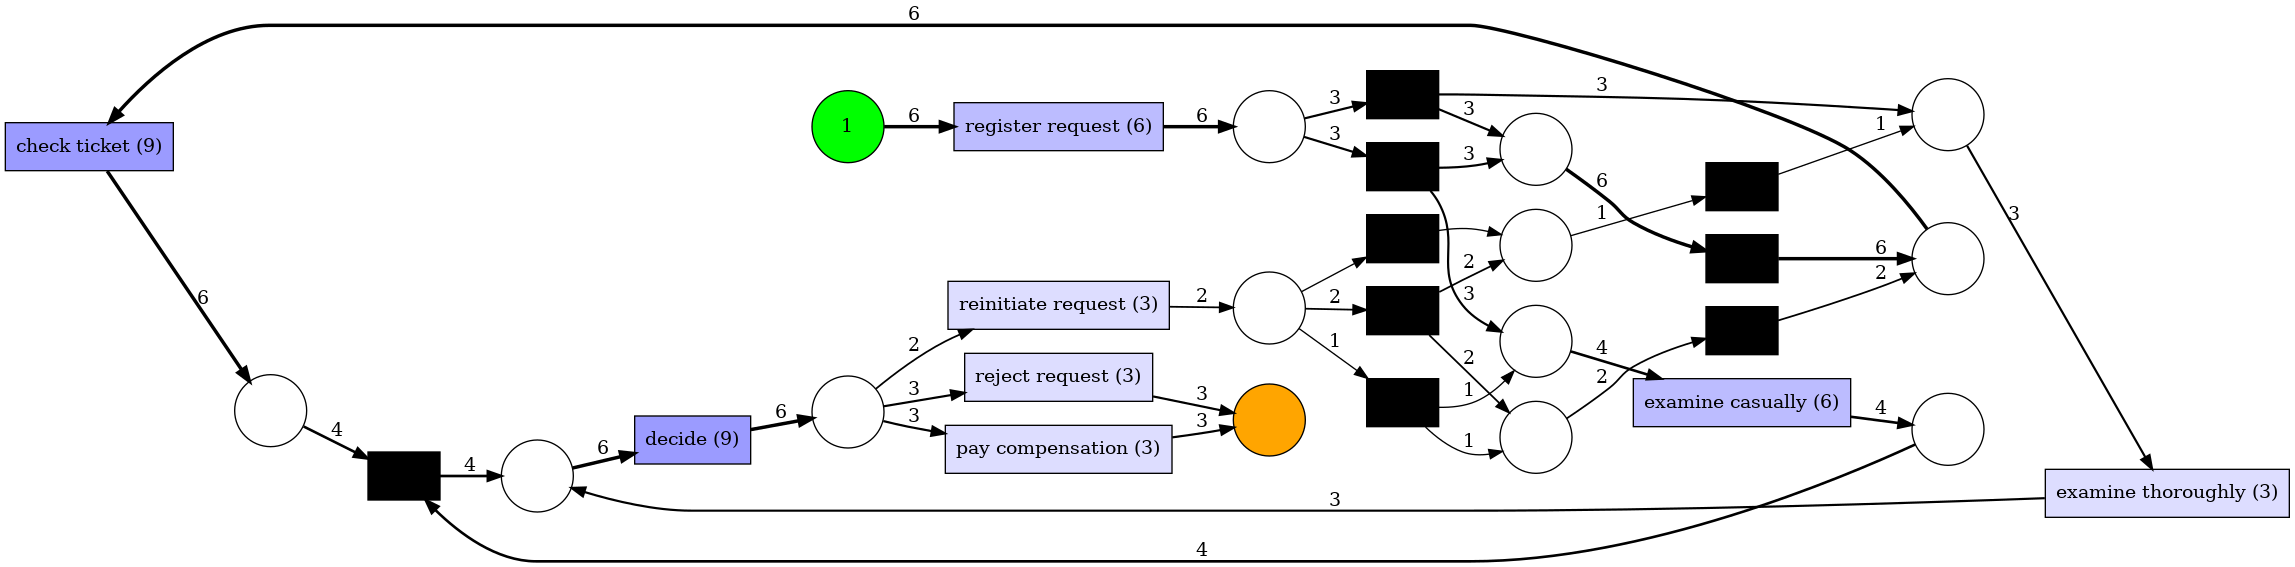

In [73]:
# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

## 4.4 Inductive Miner

Procees Mining for Python (PM4Py) offers an implementation of the inductive miner (IM), of the inductive miner infrequent (IMf), and of the inductive miner directly-follows (IMd) algorithm.

The basic idea of Inductive Miner is about detecting a 'cut' in the log (e.g. sequential cut, parallel cut, concurrent cut and loop cut) and then recur on sublogs, which were found applying the cut, until a base case is found. The Directly-Follows variant avoids the recursion on the sublogs but uses the Directly Follows graph.

Inductive miner models usually make extensive use of hidden transitions, especially for skipping/looping on a portion on the model. Furthermore, each visible transition has a unique label (there are no transitions in the model that share the same label).

Two process models can be derived: Petri Net and Process Tree.

### 4.4.1 Process Tree

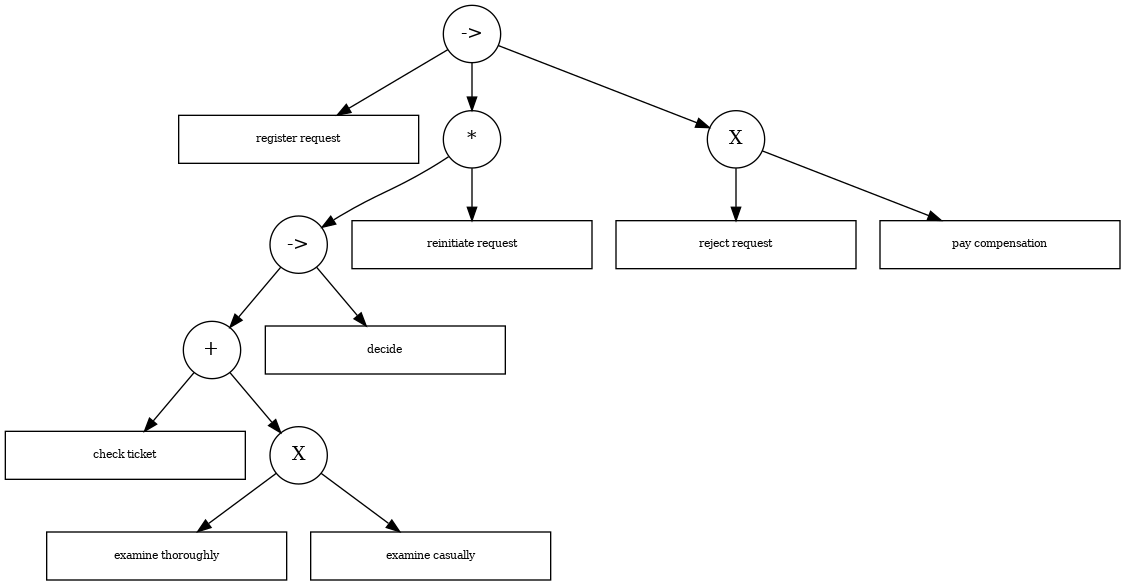

In [74]:
# Miner
tree = inductive_miner.apply_tree(log)

# GraphViz
gviz = pt_visualizer.apply(tree)

# View
pt_visualizer.view(gviz)

### 4.4.2 Convert Process Tree to Petri Net

In [75]:
# Convert the process tree to a petri net
net, initial_marking, final_marking = pt_converter.apply(tree)

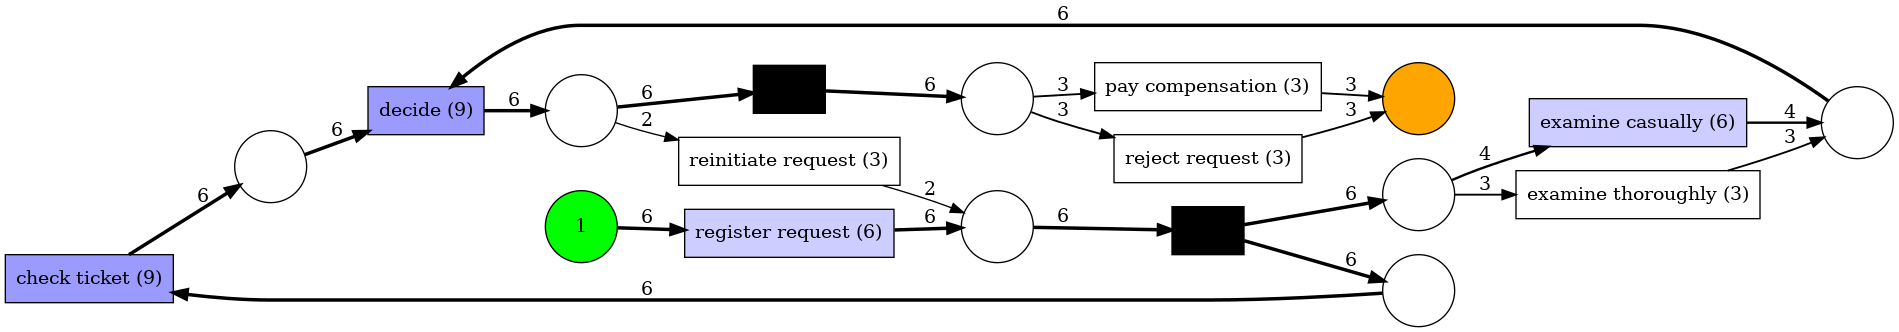

In [76]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

Same model can be generated from scratch with converting ftrom a process tree.

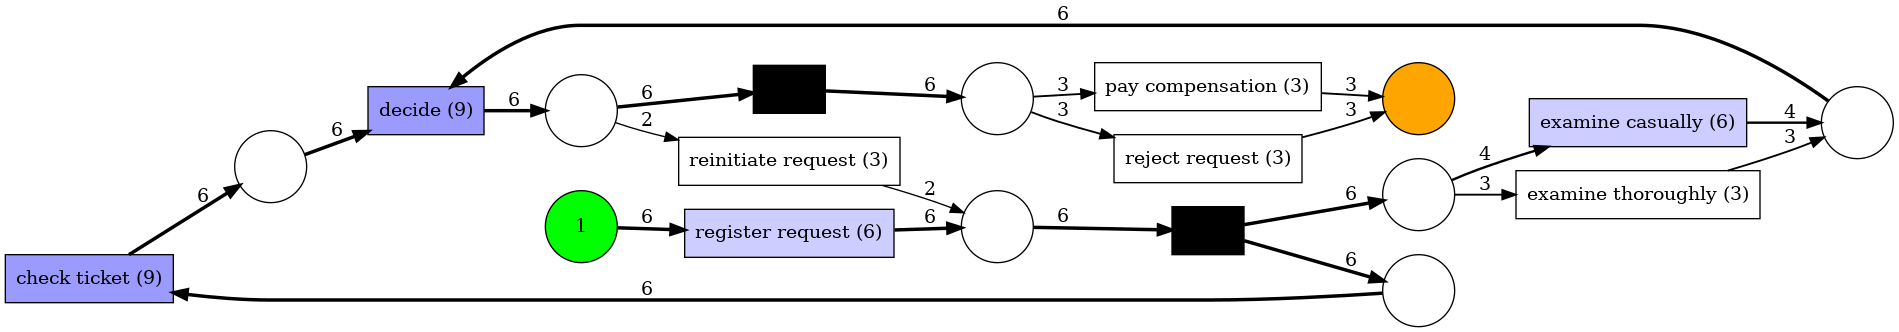

In [77]:
# Miner
net, initial_marking, final_marking = inductive_miner.apply(log)

# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

## 5. Conformance checking

## 5.1 Token-based replay

### 5.1.1 Happy Flow

In [78]:
# Create log
filtered_log = pm4py.format_dataframe(
    log_csv,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

In [79]:
# Miner
net, initial_marking, final_marking = alpha_miner.apply(log)

In [80]:
# Conformance cheching
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

In [81]:
# Result (for each trace / case)
df_replayed_traces = pd.DataFrame(replayed_traces)
df_replayed_traces['activated_transitions'] = [len(_) for _ in df_replayed_traces.activated_transitions]
df_replayed_traces.iloc[:, [0, 1, 2, 6, 7, 8, 9]]

,trace_is_fit,trace_fitness,activated_transitions,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.0,5,0,7,0,7
1,True,1.0,5,0,7,0,7
2,True,1.0,9,0,12,0,12
3,True,1.0,5,0,7,0,7
4,True,1.0,13,0,17,0,17
5,True,1.0,5,0,7,0,7


### 5.1.2 Filtered Log

In [82]:
# Create filtered/partial log: drop activity 'decide'
filtered_log = pm4py.format_dataframe(
    log_csv[~log_csv.activity.isin(['decide'])],
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

In [83]:
# Miner
net, initial_marking, final_marking = alpha_miner.apply(filtered_log)

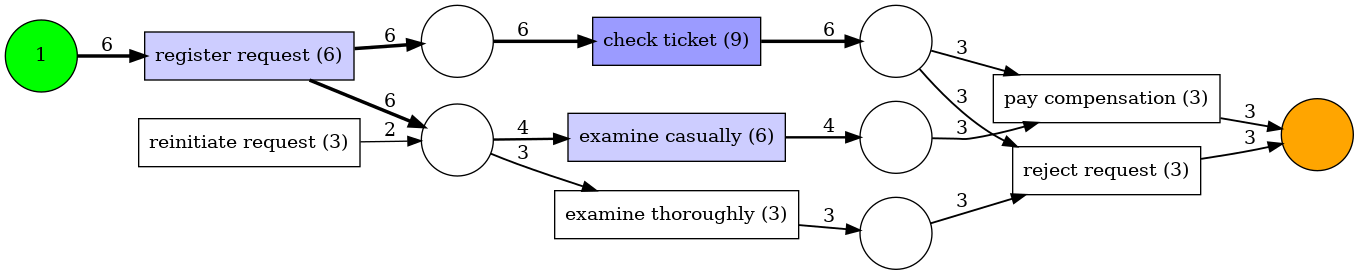

In [84]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(
    net, initial_marking, final_marking,
    parameters = parameters, 
    variant = pn_visualizer.Variants.FREQUENCY, 
    log = filtered_log
)

# View
pn_visualizer.view(gviz)

In [85]:
# Conformance ckeching
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

In [86]:
# Result (for each trace / case)
df_replayed_traces = pd.DataFrame(replayed_traces)
df_replayed_traces['activated_transitions'] = [len(_) for _ in df_replayed_traces.activated_transitions]
df_replayed_traces.iloc[:, [0, 1, 2, 6, 7, 8, 9]]

,trace_is_fit,trace_fitness,activated_transitions,missing_tokens,consumed_tokens,remaining_tokens,produced_tokens
0,True,1.000000,4,0,6,0,6
1,True,1.000000,4,0,6,0,6
2,False,0.826389,7,1,8,2,9
3,True,1.000000,4,0,6,0,6
4,False,0.641667,10,3,10,5,12
5,True,1.000000,4,0,6,0,6


# 6. Throughput analysis/bottleneck detection

## 6.1 Case durations

In [87]:
all_case_durations = case_statistics.get_all_casedurations(log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})

In [88]:
all_case_durations

[520920.0, 703320.0, 779580.0, 852300.0, 1368780.0, 1576440.0]

In [89]:
median_case_duration = case_statistics.get_median_caseduration(log, parameters={
    case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"
})

In [90]:
median_case_duration

852300.0

#### Trying to reproduce results ...

In [91]:
def case_duration(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='s') -> pd.DataFrame:
    """
    Returns a list with case durations.
    By default duration is set to hours (h). Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    data = dict()
    groups = log_csv.groupby(case_var)
    for group in groups:
        grp = group[1].sort_values(timestamp_var)
        start_time = grp[timestamp_var].iloc[0]
        end_time = grp[timestamp_var].iloc[-1]
        case_duration = (end_time - start_time) / np.timedelta64(1, duration)
        data[group[0]] = [case_duration, start_time, end_time]
    return data

In [92]:
# case duration
cd = case_duration(log, 'case_id', 'activity', 'timestamp', duration = 's')

In [93]:
# case_duration
df = pd.DataFrame(cd).T.reset_index()\
.rename(columns= {'index':'case', 0:'duration', 1:'start_datetime', 2:'end_datetime'})\
.set_index('case')
df

,duration,start_datetime,end_datetime
case,,,
1,703320.0,2010-12-30 10:02:00+00:00,2011-01-07 13:24:00+00:00
2,779580.0,2010-12-30 10:32:00+00:00,2011-01-08 11:05:00+00:00
3,1368780.0,2010-12-30 13:32:00+00:00,2011-01-15 09:45:00+00:00
4,520920.0,2011-01-06 14:02:00+00:00,2011-01-12 14:44:00+00:00
5,1576440.0,2011-01-06 08:02:00+00:00,2011-01-24 13:56:00+00:00
6,852300.0,2011-01-06 14:02:00+00:00,2011-01-16 10:47:00+00:00


In [94]:
df.duration.mean()

966890.0

**Resources:**
- PM4PY [documentation](https://pm4py.fit.fraunhofer.de/documentation)
- PM4Py [documentation](http://pm4py.pads.rwth-aachen.de/documentation/) (older version?)
- Towards Data Science story [Introduction to Process Mining](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5)
- Process Mining for Python on [Youtube](https://www.youtube.com/channel/UCRcgOKrDsntrTI78RXXliuw/videos)
- Wikipedia page [process mining](https://en.wikipedia.org/wiki/Process_mining)
- Wikipedia page [Petri net](https://en.wikipedia.org/wiki/Petri_net)
- Alpha Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15636)
- Heuristics Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15639)
- Inductive Miner [video](https://www.futurelearn.com/info/courses/process-mining/0/steps/15642)
- Workflow Net and Soundness [video](https://www.coursera.org/lecture/process-mining/2-5-workflow-nets-and-soundness-tBnqo)
- Process Mining Manifestio ([pdf-document](https://www.win.tue.nl/ieeetfpm/downloads/Process%20Mining%20Manifesto.pdf))
